The nv center paper https://pubs.aip.org/avs/aqs/article/2/2/024701/997281/Introduction-to-quantum-optimal-control-for has an example of a control pulse for just the zeeman term of the Hamiltonian.  I want to replicate this and put it in GRAPE to try to understand how to deal with the B-field being aligned or not aligned with the NV-axes.

In [80]:
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi

from scipy.constants import physical_constants, h
from dataclasses import dataclass

from qutip import *
from qutip.control import *
from qutip.qip.operations import rx
from qutip.qip.operations import ry
from qutip.qip.operations import rz

from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.cy_grape import cy_overlap
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

For this notebook we are considering a single NV center with an applied magnetic field.  The parallel component of the field $B_{\parallel}$ is along the z-axis and the perpendicular component of the field $\vec{B_{perp}}$ is a circularly polarized microwave field with phase $\phi$, frequency $\omega_{mw}$, and amplitude $B_{\perp}(t)$

The Zeeman splitting term of the Hamiltonian is $H_{Zeeman} = \gamma_{nv} \vec{B} \cdot \vec{s}$ and after
 rotating into the microwave frequency, you get the following Hamiltonian, which is the drift Hamiltonian.  

$H_{RWA} = \Delta \hat{s}_{z} + \Omega (cos(\phi)\hat{s}_{x} + sin(\phi)\hat{s}_{y})$

The constants here are: $\Delta = \omega_{nv} - \omega_{mw}$ is the detuning, 

$\omega_{nv} = B_{\parallel}\gamma_{nv}$ is the NV resonant frequency,

$\Omega(t) = B_{\perp}\gamma_{nv}$ is the Rabi frequency,

and $\vec{s}$ are the Pauli operators for spin-1/2 

The following cells are to write the Hamiltonian using the rotating wave approximation

In [81]:
R = 500
H_ops = [sigmax(), sigmay()]

#Labels for the graph
H_labels = [r'$u_{x}$',
            r'$u_{y}$',
        ]

In [82]:
#defining constants in hamiltonian
h= 6.582119 * 1e-16 #eV * sec 
Bperpendicular = 10 #mT
Bparallel = 10 #mT
gammanv = 2*np.pi*28 * 1000000 #Hz/mT
omeganv = Bparallel * gammanv
omegamw = 1000000000 #Hz
Delta = omeganv - omegamw
Omega = Bperpendicular * gammanv
Omega

1759291886.0102842

We are going to work in frequency units, additionally we are going to divide all of the necessary constants by a factor of 1e

In [83]:
#here is also where I divide Delta and Omega by a factor of a billion
#and round up to give it these values

h=1
Delta = 8
Omega = 18
H0= h*Delta*sigmaz() + sigmax() + sigmay()

H0

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 8.+0.j  1.-1.j]
 [ 1.+1.j -8.+0.j]]

In [84]:
#creating transform matrix

phi=(np.pi)
U = 1*rx(phi)
U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.+0.j 0.-1.j]
 [0.-1.j 0.+0.j]]

# Doing GRAPE

In [85]:
#doing GRAPE!
R = 500
#GRAPE iterations, 150 is a good number to test that it is doing what you want it to, 500 gives you decent fidelity
#T here is 1/Omega,  I just manually put the 18 in here in case it didn't like having a variable there?? 
T = 10/18
times = np.linspace(0, T, 1000)
u0 = np.array([np.random.rand(len(times)) * 2 * pi * 0.005 for _ in range(len(H_ops))])
u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

In [86]:
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2*pi/T, phase_sensitive=False,
                          progress_bar=TextProgressBar())

10.0%. Run time: 101.57s. Est. time left: 00:00:15:14
20.0%. Run time: 202.80s. Est. time left: 00:00:13:31
30.0%. Run time: 303.87s. Est. time left: 00:00:11:49
40.0%. Run time: 405.60s. Est. time left: 00:00:10:08
50.0%. Run time: 508.17s. Est. time left: 00:00:08:28
60.0%. Run time: 610.21s. Est. time left: 00:00:06:46
70.0%. Run time: 711.49s. Est. time left: 00:00:05:04
80.0%. Run time: 812.77s. Est. time left: 00:00:03:23
90.0%. Run time: 913.72s. Est. time left: 00:00:01:41
Total run time: 1012.68s


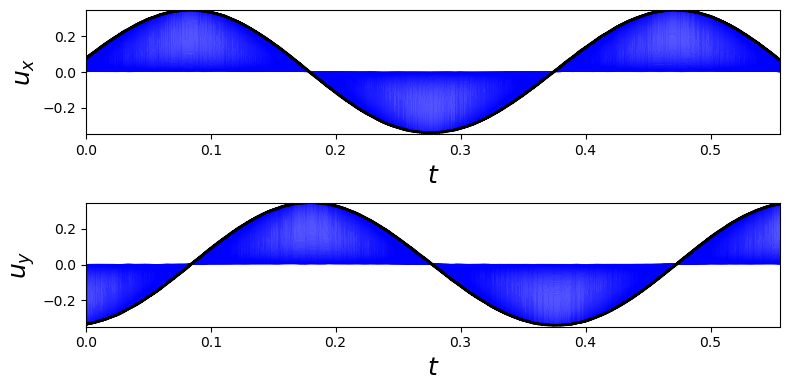

In [87]:
#Plotting pulse sqeuences from GRAPE
plot_grape_control_fields(times, result.u[:,:,:] / (2 * pi), H_labels, uniform_axes=True);

# Testing our Unitary

In [88]:
#printing resultant Unitary from the final iteration of GRAPE
startingstate = Qobj([[1.],
                      [0.]])
result.U_f

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[-0.0547456 +0.2462884j   0.03265134+0.96709815j]
 [-0.03265134+0.96709815j -0.0547456 -0.2462884j ]]

In [94]:
#printing the final state from the resultant Unitary
finalstate = result.U_f*startingstate
finalstate

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.0547456 +0.2462884j ]
 [-0.03265134+0.96709815j]]

In [93]:
#Printing the ideal final state
idealfinalstate = U*startingstate
idealfinalstate

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.+0.j]
 [0.-1.j]]

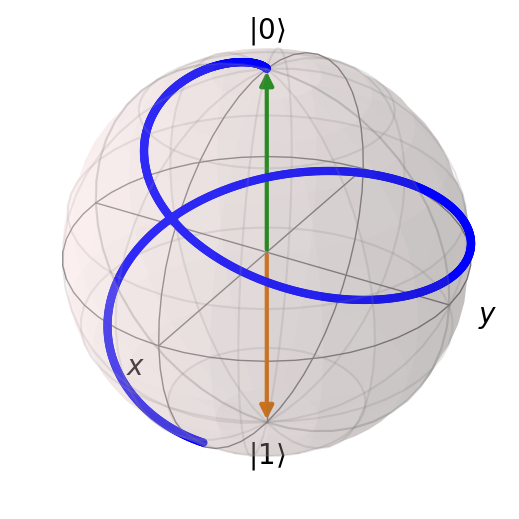

In [91]:
#plotting the initial and final states on the Bloch sphere as well as the intermediate states (blue dots)
c_ops = []
e_ops = [sigmax(), sigmay(), sigmaz()]
me_result = mesolve(result.H_t, startingstate, times, c_ops, e_ops)
b = Bloch()

b.add_points(me_result.expect)

b.add_states(startingstate)
b.add_states(U * startingstate)
b.render()
b.show()

In [92]:
#finding Fidelity

idealdensitymatrix=(idealfinalstate * idealfinalstate.dag())#ideal density matrix
densitymatrix=(finalstate * finalstate.dag())# real density matrix
print (idealdensitymatrix)
print (densitymatrix)
fidelity(idealdensitymatrix,densitymatrix)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.06365506+0.j         0.23997257+0.04490272j]
 [0.23997257-0.04490272j 0.93634494+0.j        ]]


0.9676491847682738